In [1]:
# Load the "autoreload" extension
#%load_ext autoreload

#reload extension
%reload_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 2

#Import all the necessary packages for modules
import os
import sys

#add the 'python' directory as one where we can import modules
py_dir = os.path.join(os.getcwd(), 'python')
sys.path.append(py_dir)

# import my method from the source code
from python.get_info import plot_hists, plot_violin

In [2]:
#Import all necessary packages for visualization and transformation of the data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# PRE-PROCESSING

In [52]:
#upload training set and change dtypes for visitor_id and label to a categorical object
train = pd.read_csv('data/train_20170701_to_20170731', index_col=0, dtype={'visitor_id': 'object'})
train.head()

,visitor_id,day0_time_on_site_seconds,day1_time_on_site_seconds,day2_time_on_site_seconds,day3_time_on_site_seconds,day4_6_time_on_site_seconds,w2_time_on_site_seconds,day0_hits,day1_hits,day2_hits,...,day3_sessions,day4_6_sessions,w2_sessions,day0_session_quality,day1_session_quality,day2_session_quality,day3_session_quality,day4_6_session_quality,w2_session_quality,label
0,3092487309701391768,570.0,NaN,1021.0,NaN,NaN,533.0,26.0,NaN,6.0,...,NaN,NaN,2.0,60.0,NaN,3.0,NaN,NaN,1.5,1
1,780253600713375371,705.0,NaN,NaN,NaN,NaN,1181.0,58.0,NaN,NaN,...,NaN,NaN,1.0,85.0,NaN,NaN,NaN,NaN,79.0,1
2,953713676730854570,373.0,NaN,NaN,NaN,NaN,736.0,42.0,NaN,NaN,...,NaN,NaN,1.0,76.0,NaN,NaN,NaN,NaN,65.0,1
3,238925310298938861,1919.0,NaN,NaN,NaN,14.0,691.0,74.0,NaN,NaN,...,NaN,1.0,2.0,79.0,NaN,NaN,NaN,1.0,43.5,1
4,1090774782213816251,2405.0,NaN,NaN,NaN,0.0,454.0,33.0,NaN,NaN,...,NaN,1.0,2.0,87.0,NaN,NaN,NaN,1.0,3.0,1


In [4]:
train.label.value_counts()/len(train.label)

0    0.951713
1    0.048287
Name: label, dtype: float64

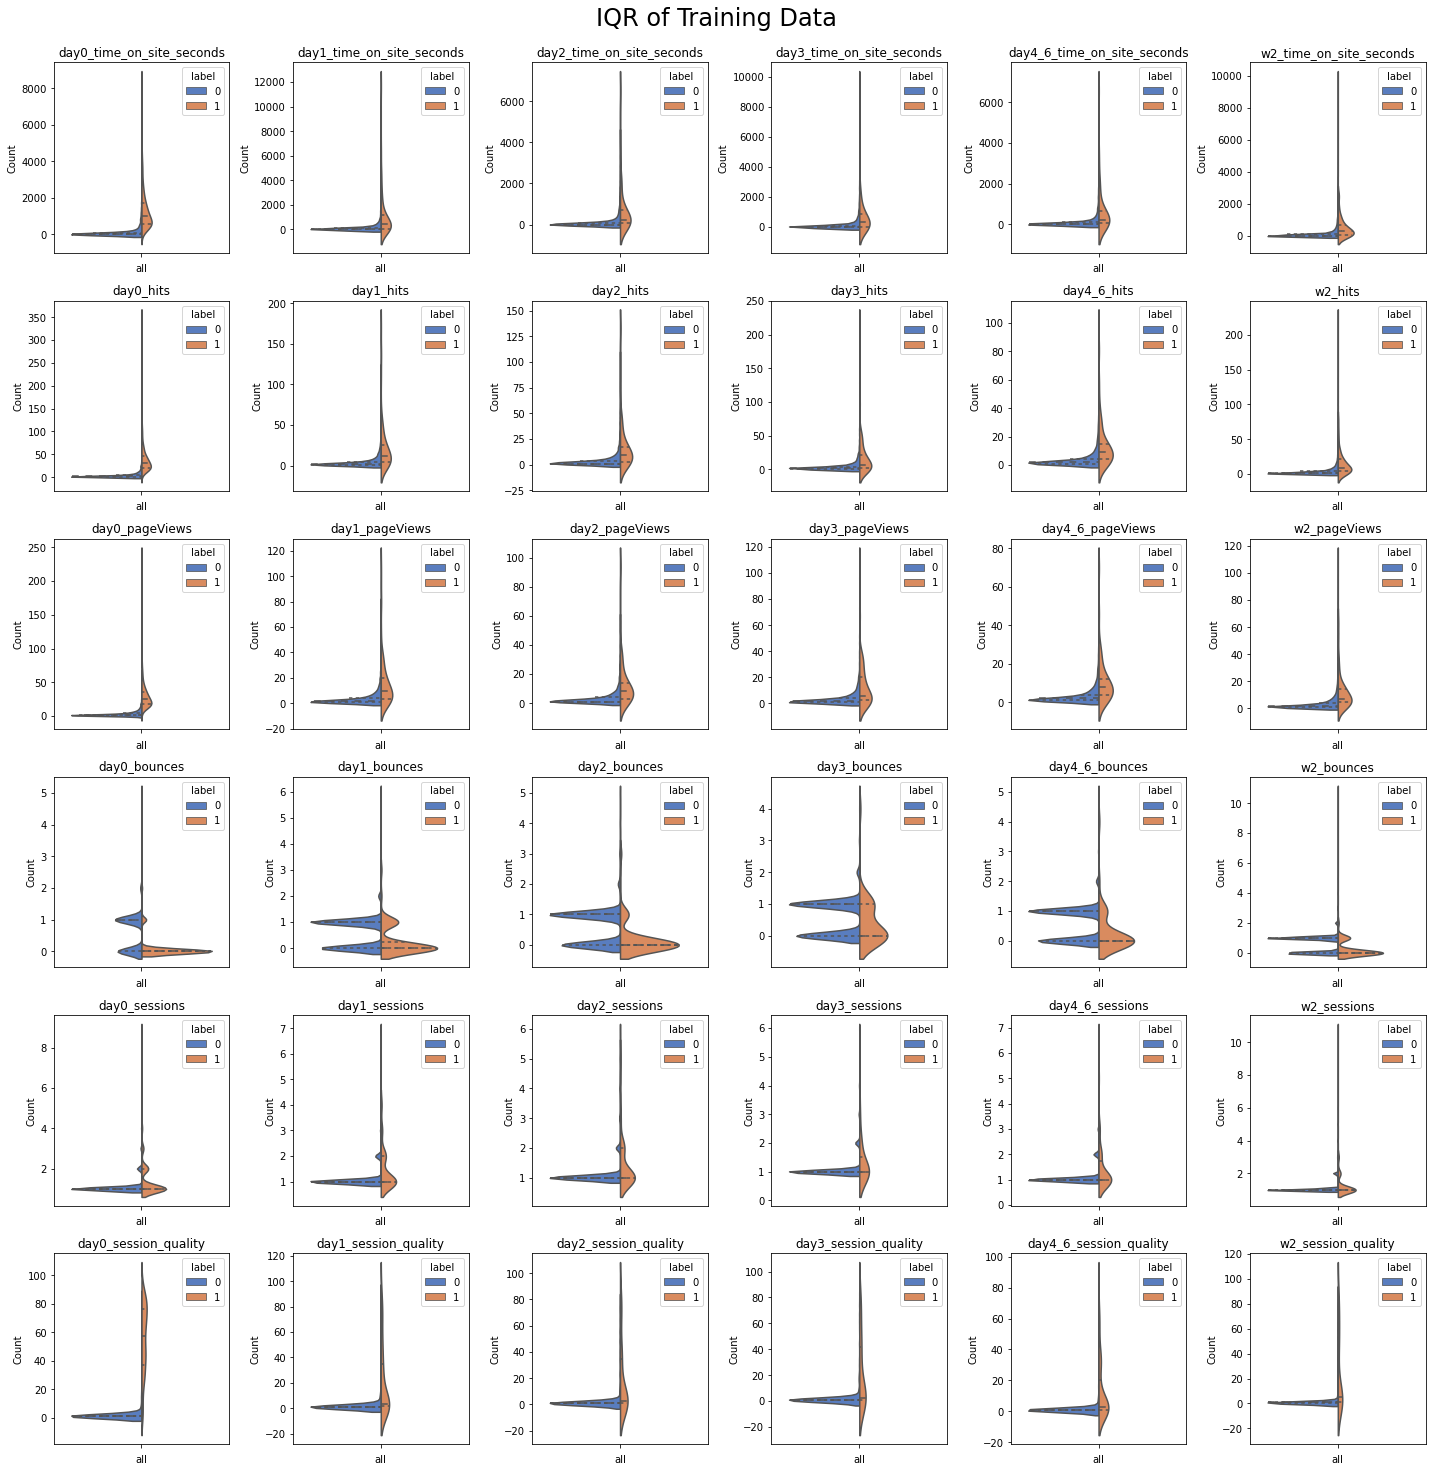

In [5]:
#create blank column to plot violin boxplot
train['all']=''

#plot violin boxplot
plot_violin(train, 'IQR of Training Data')

#remove blank column
train = train.iloc[:,:-1]

Looking at a preview of the data once again and at the percentage of customers who don't purchase (label 0) vs. customers who do purchase (label 1), we can see that customers who make a purchase make up less than 5% of the dataset despite already downsampling customers who don't purchase. In other words, the data is highly imbalanced and customers making a purchase is considered a rare event. The violin boxplot also shows that there are significant outliers in the data.

We will perform each the following pre-processing techniques to mitigate any biases and inaccuracies in predicting customer propensity:

- __Scaling (Standardization)__
- __Imputing__ - the null values in the data are meaningful; they represent the days that each visitor was _not_ present on the site. We can impute the data by filling each null value with zeroes to represent this.

### IMPUTE MISSING DATA

In [53]:
train.fillna(0, inplace=True)

### SCALE THE DATA

#### STANDARDIZATION

In [7]:
scaler = StandardScaler()

#Create a new dataframe, whilst setting the index to 'visitor_id'
train_scale = train.set_index('visitor_id')

#Save the column names (using the `columns` attribute)
train_scale_columns = train_scale.iloc[:,:-1].columns

#Fit to scaler, except for labels
scaler.fit((train_scale.iloc[:,:-1]))

#Transform the data
scaled = scaler.transform(train_scale.iloc[:,:-1])

#Create a new dataframe using the column names
train_scaled = pd.DataFrame(scaled, columns=train_scale_columns)

#insert visitor_id and labels
train_scaled.insert(0, 'visitor_id', train.visitor_id)
train_scaled['label'] = train['label']

Let's confirm that the data has been normalized

In [8]:
train_scaled.describe().T[['mean', 'std']]

,mean,std
day0_time_on_site_seconds,5.509669e-14,1.000025
day1_time_on_site_seconds,7.187973e-15,1.000025
day2_time_on_site_seconds,-3.115331e-15,1.000025
day3_time_on_site_seconds,7.010883e-16,1.000025
day4_6_time_on_site_seconds,1.453753e-15,1.000025
w2_time_on_site_seconds,-2.404013e-15,1.000025
day0_hits,3.466084e-14,1.000025
day1_hits,2.475916e-15,1.000025
day2_hits,-7.195734e-16,1.000025
day3_hits,-1.492536e-16,1.000025


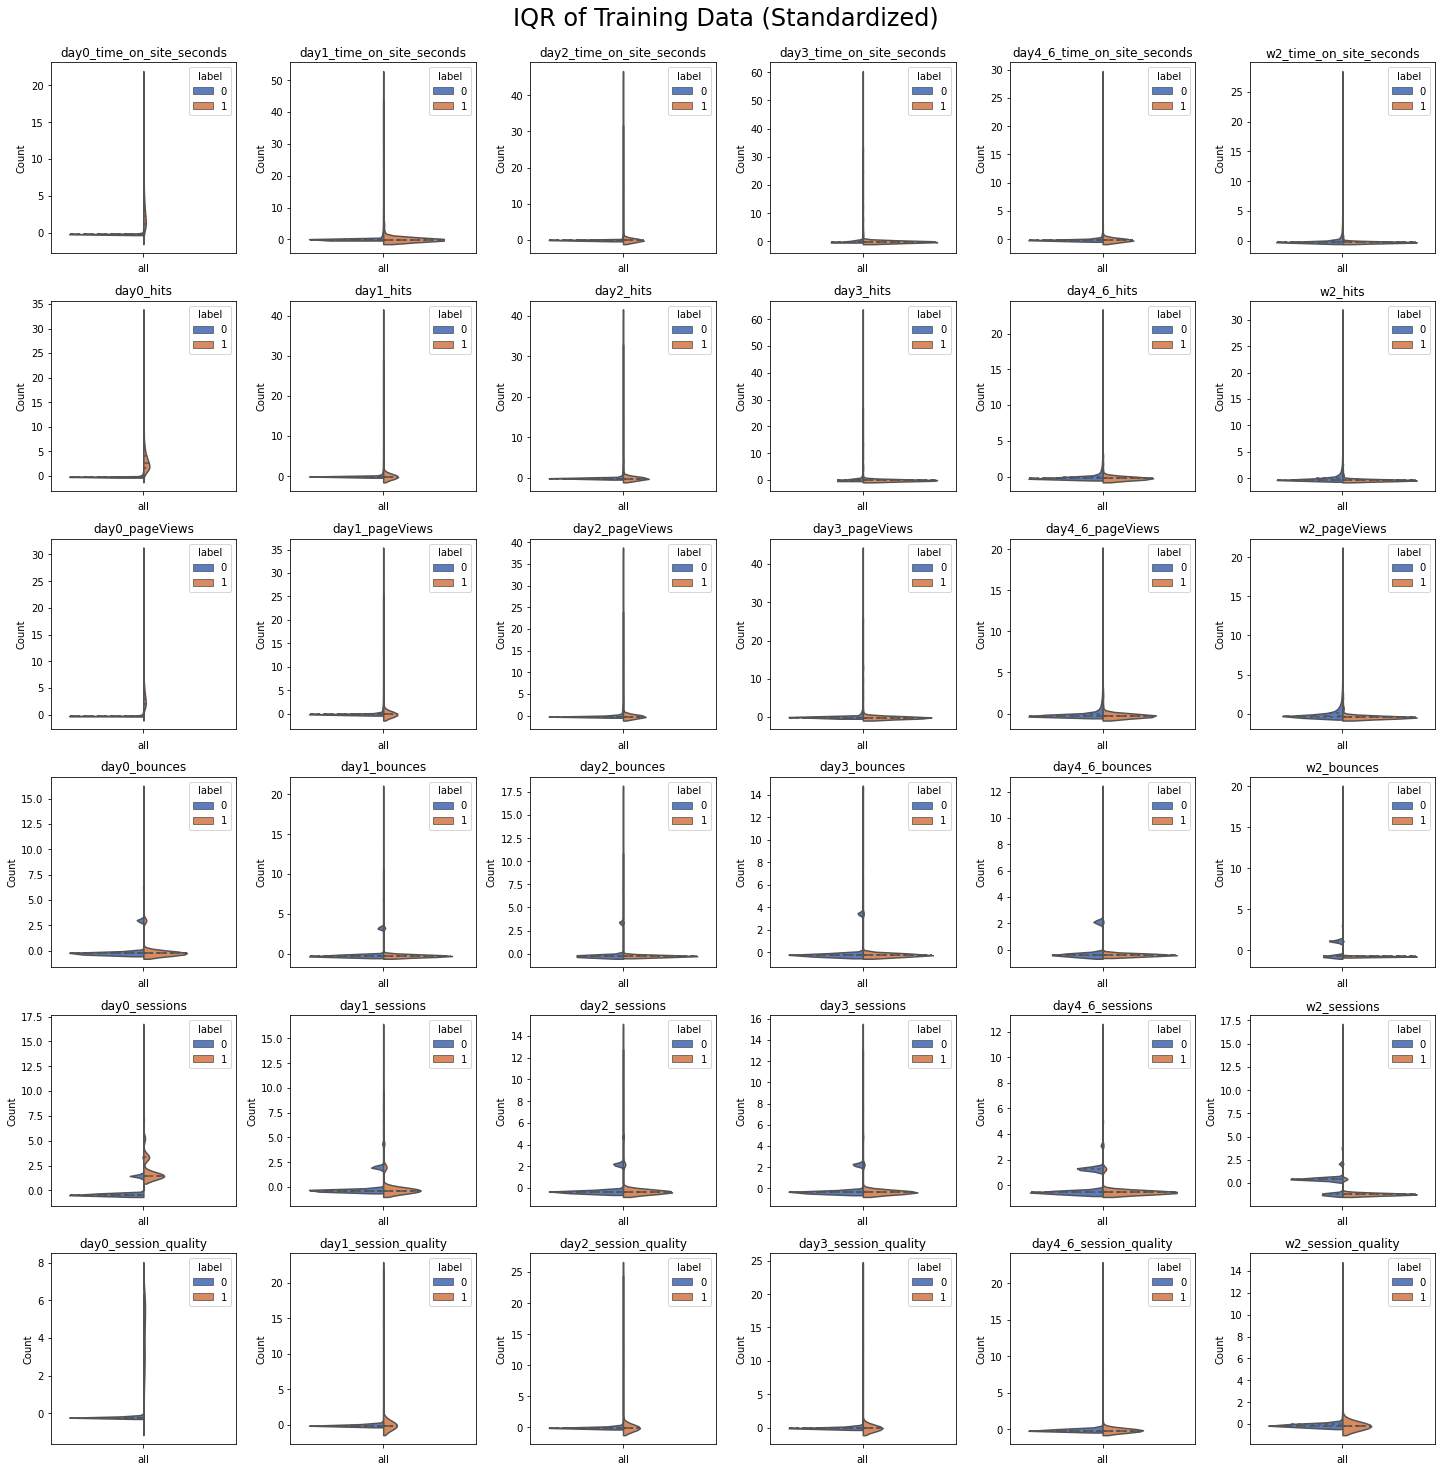

In [9]:
#create blank column to plot violin boxplot
train_scaled['all']=''
plot_violin(train_scaled, 'IQR of Training Data (Standardized)')
#remove blank column
train_scaled = train_scaled.iloc[:,:-1]

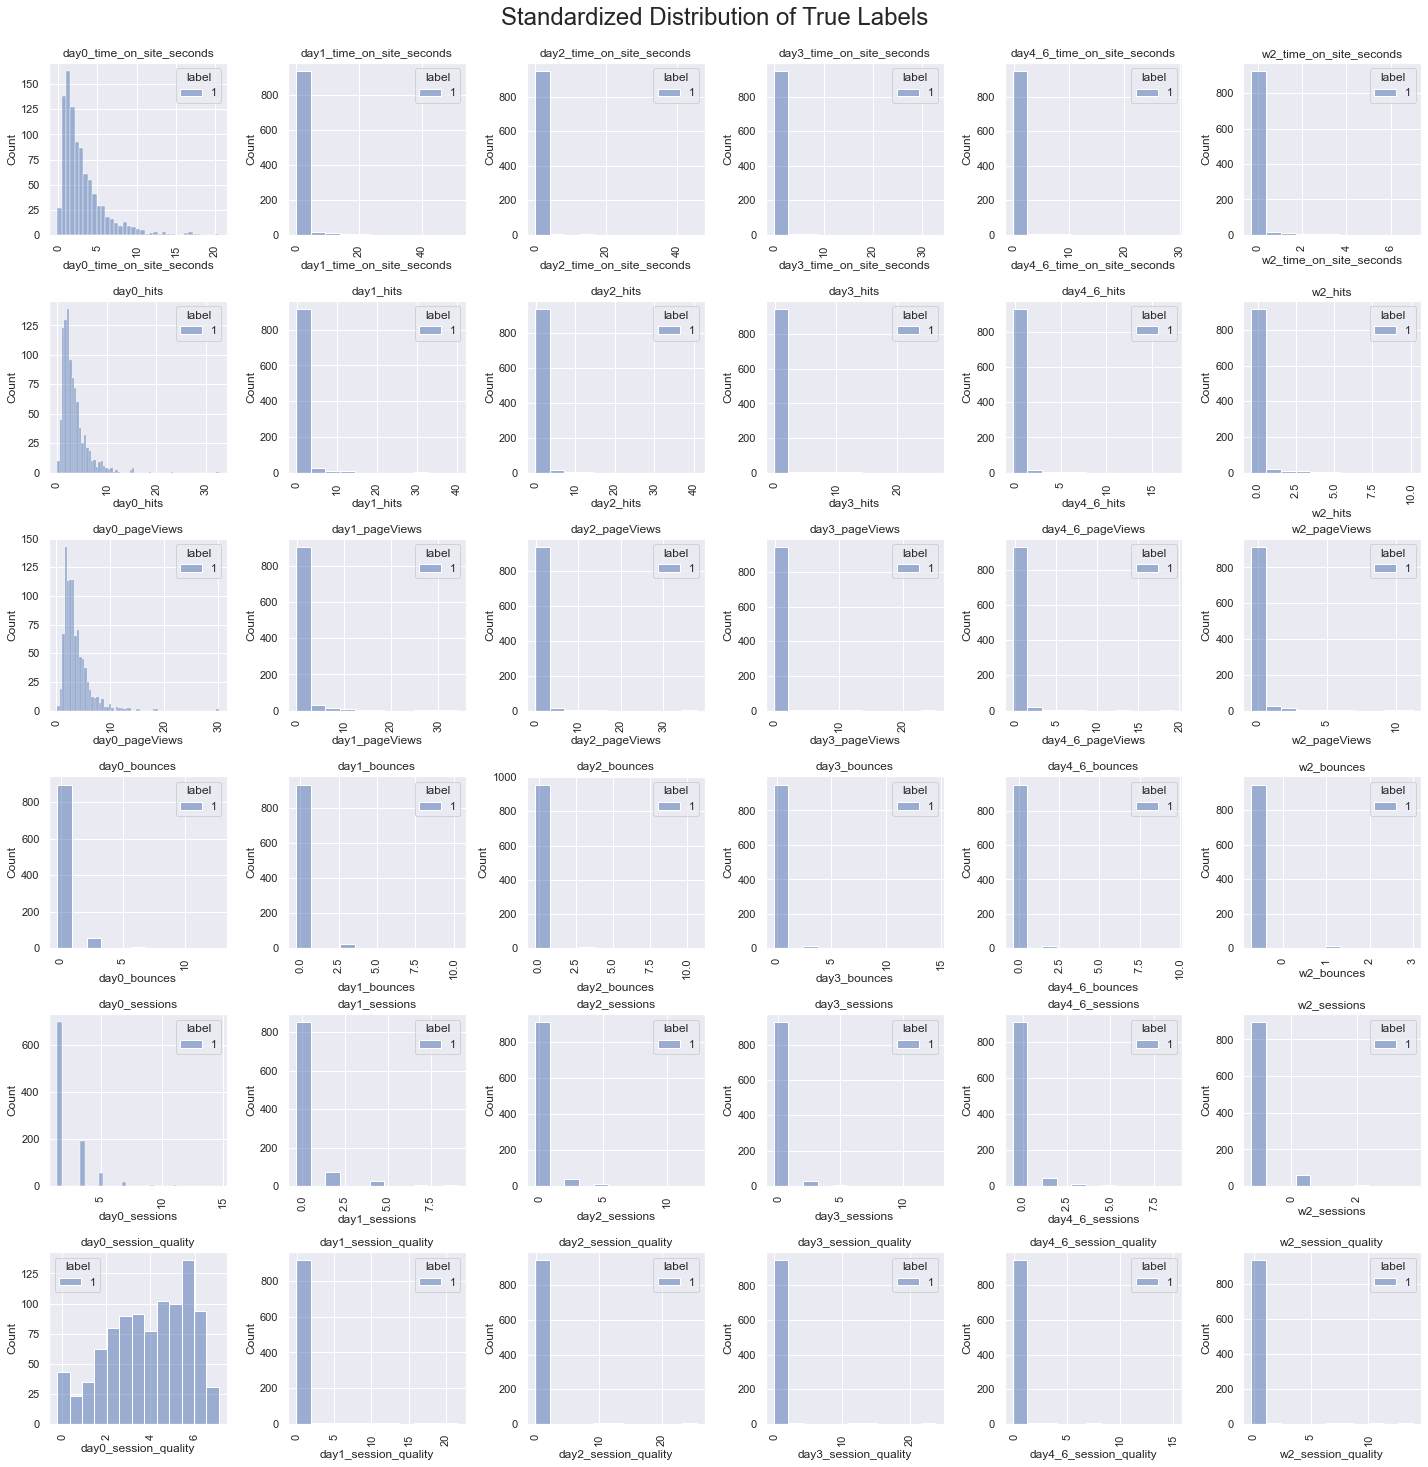

In [10]:
plot_hists(train_scaled[train_scaled.label ==1 ], 'Standardized Distribution of True Labels')

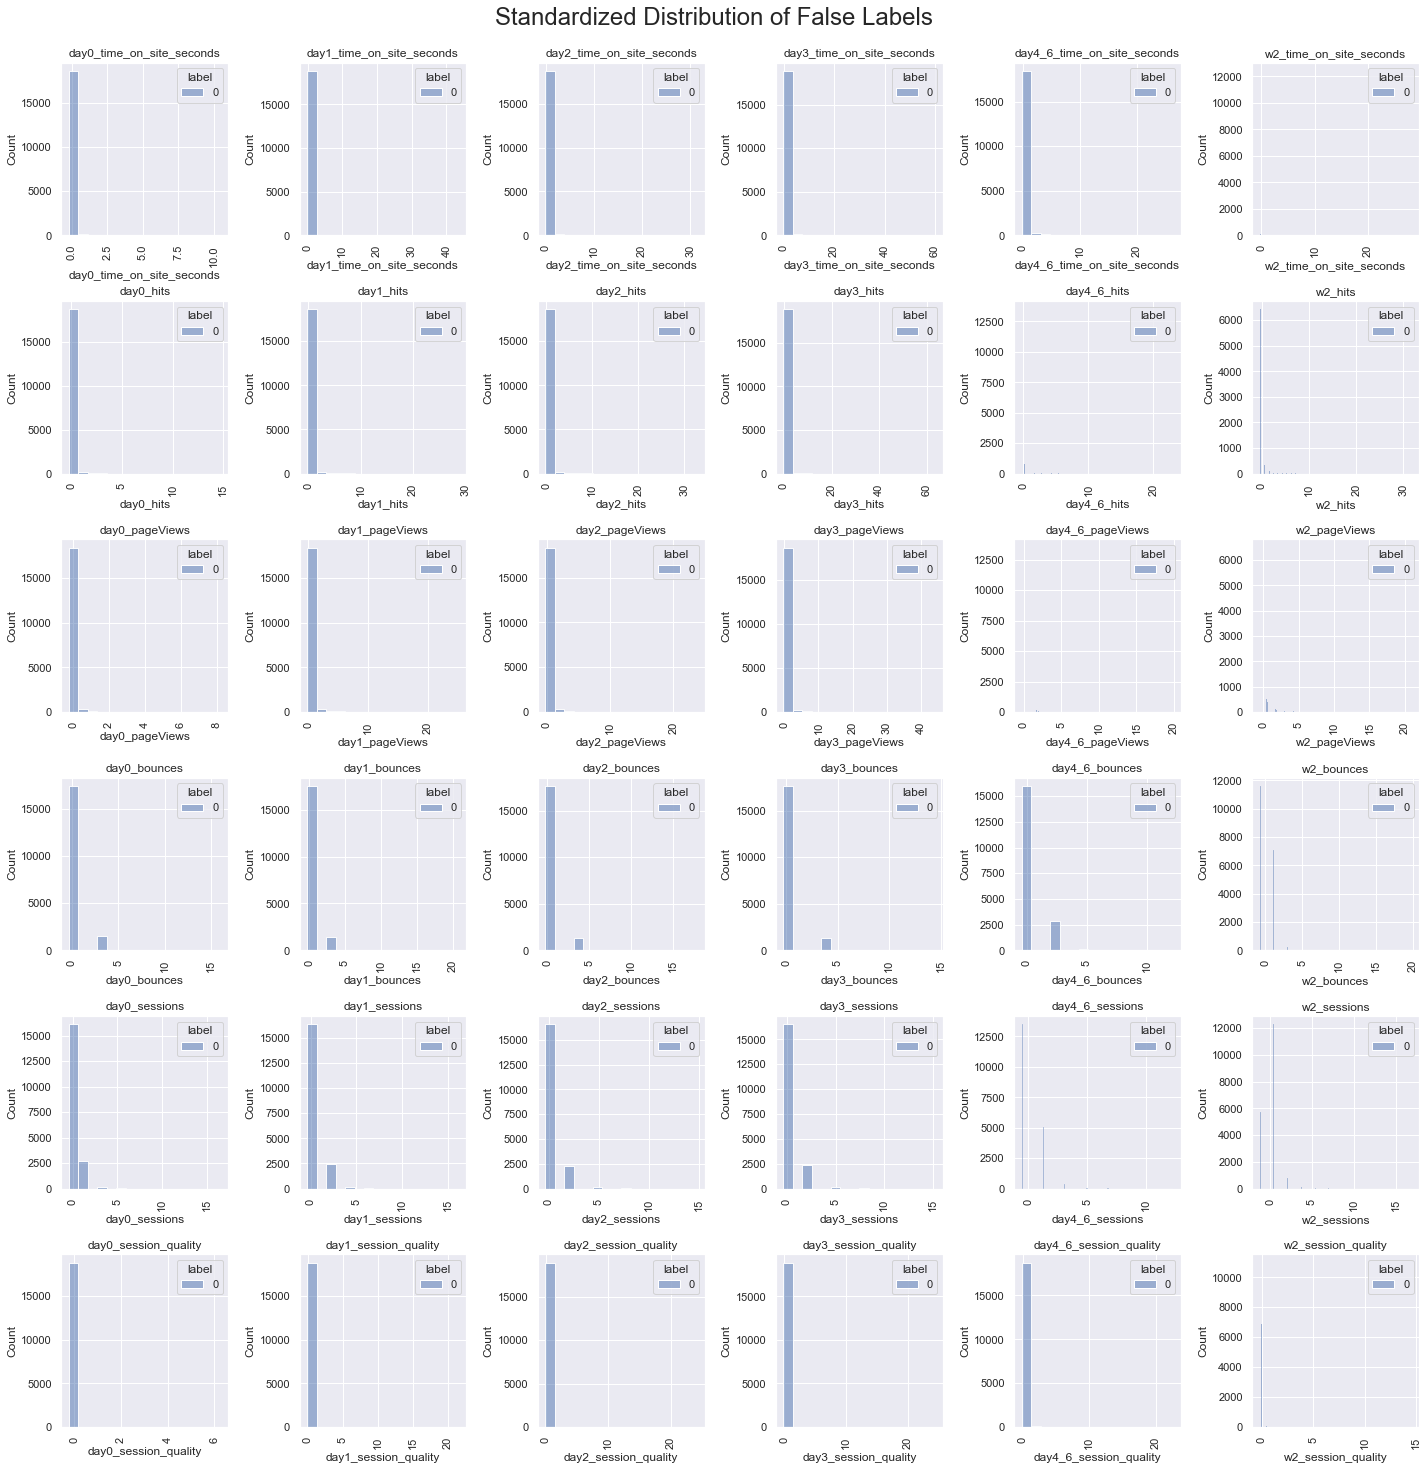

In [11]:
plot_hists(train_scaled[train_scaled.label ==0 ], 'Standardized Distribution of False Labels')

It looks like scaling the data down did normalize the standard deviation close to 1 and the mean close to 0. However, based off of the histogram and violin plot, it looks like we are still dealing with very large outliers and a skewed distribution.

# MODELING

In [12]:
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from catboost import Pool
import scikitplot as skplt
import shap

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

We will be using the following models for our transformations:

- CatBoost
- Random Forest
- Logistic Regression

We will be using __StandardScaler()__ in a pipeline with each model. First, we need to split our data into features and the target variable.

In [54]:
X = train.iloc[:,:-1]
y = train[['label']]

### CATBOOST

In [55]:
def catboost_model(X, y, iterations=50):
    
    #get categorical features
    #cat_var = np.where(X_train.dtypes != np.float)[0]
    #print(f'\nCategorical Variables indices : {cat_var}')
    
    #initialize the model with pipeline
    model = Pipeline([('standard_scaler', StandardScaler()),
                      ('cat_boost', CatBoostClassifier(iterations=iterations))])#, cat_features = cat_var))])
    print(f'\nTraining CatBoost Model..........')

    # fit the model with the data
    model.fit(X, y)#, plot=False)
    print('\n Model Trained')

    # predict the target on the dataset
    y_pred = model.predict(X)
    print(f'\nTarget on data {y_pred}') 

    # Accuracy Score on train dataset
    accuracy = accuracy_score(y, y_pred)
    print(f'\nAccuracy_score on dataset : {accuracy}')
    
    # Predict the probability score for each label
    proba_list = model.predict_proba(X)
    print(f'\nProbability score for each label: {proba_list}')
    
    # Get overall feature importance
    shap_values = model.named_steps['cat_boost'].get_feature_importance(Pool(X, 
                                                                             label = y, 
                                                                             #cat_features = cat_var
                                                                             ), type="ShapValues")
    shap.summary_plot(shap_values[:,:-1], X)
    
    return y, y_pred, proba_list

In [56]:
def lift(df):
    
    # rank the predictions made for a test set in descending order by prediction score
    df.sort_values(by='proba', ascending=False, inplace=True)
    
    # split data into deciles or groups of 10
    cuts = 10
    df['ntile'] = pd.qcut(df.proba.rank(method='first'), q=cuts, labels=range(1, cuts+1))
    
    # calculate per decile counts for positives and negatives rows
    df_new = df.copy(deep=True)
    df_new = df.groupby(['ntile','label']).proba.count().reset_index(name='count')
    
    # go from row to columns wise using pivot two join to data frames
    col = ['label','ntile', 'count']
    df_pos=df_new[df_new.label==1][col]
    df_neg=df_new[df_new.label==0][col]
    df_final = pd.merge(df_neg,df_pos, on='ntile',how='left', suffixes=('_neg','_pos'))
    
    # calculate lift 
    df_final['lift'] = df_final.count_pos/df_final.count_neg /(df_final.count_pos.sum()/df_final.count_neg.sum())
    
    return df_final

In [57]:
def plot_roc(y_test, y_pred, Model, Label ='No Transformation'):
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    
    plt.figure(figsize=(10,10))
    plt.plot([0,1], [0,1], 'k--')
    plt.plot(fpr, tpr, label = f'{Model}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{Model} - {Label} - ROC Curve')
    plt.show()
    
    return None


Training CatBoost Model..........
Learning rate set to 0.5
0:	learn: 0.0541880	total: 6.78ms	remaining: 332ms
1:	learn: 0.0202856	total: 13.6ms	remaining: 326ms
2:	learn: 0.0162419	total: 20.8ms	remaining: 327ms
3:	learn: 0.0146005	total: 30.1ms	remaining: 346ms
4:	learn: 0.0140843	total: 39ms	remaining: 351ms
5:	learn: 0.0139544	total: 47.2ms	remaining: 346ms
6:	learn: 0.0124180	total: 56ms	remaining: 344ms
7:	learn: 0.0118048	total: 64.6ms	remaining: 339ms
8:	learn: 0.0116537	total: 73.6ms	remaining: 335ms
9:	learn: 0.0110151	total: 82.5ms	remaining: 330ms
10:	learn: 0.0109942	total: 89.3ms	remaining: 317ms
11:	learn: 0.0106156	total: 96.8ms	remaining: 306ms
12:	learn: 0.0103393	total: 103ms	remaining: 294ms
13:	learn: 0.0098291	total: 111ms	remaining: 284ms
14:	learn: 0.0093731	total: 117ms	remaining: 274ms
15:	learn: 0.0089573	total: 124ms	remaining: 264ms
16:	learn: 0.0087622	total: 131ms	remaining: 254ms
17:	learn: 0.0087514	total: 138ms	remaining: 245ms
18:	learn: 0.0084859	tot

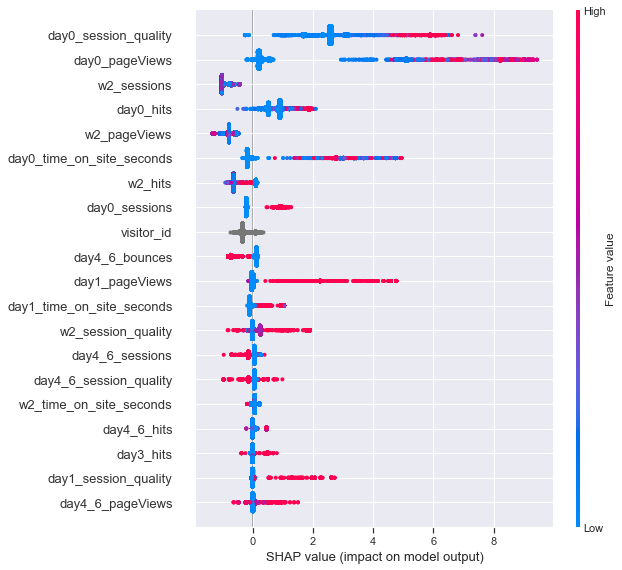

In [58]:
y, y_pred, proba = catboost_model(X, y)

In [59]:
df = pd.DataFrame({'label' : y_pred, 'proba' : proba[:,1]})

In [60]:
lift_cat = lift(df)
lift_cat.to_csv('metrics/lift_catboost.csv')
lift_cat

,label_neg,ntile,count_neg,label_pos,count_pos,lift
0,0,1,1997,1,0,0.000000
1,0,2,1996,1,0,0.000000
2,0,3,1996,1,0,0.000000
3,0,4,1997,1,0,0.000000
4,0,5,1996,1,0,0.000000
5,0,6,1996,1,0,0.000000
6,0,7,1997,1,0,0.000000
7,0,8,1996,1,0,0.000000
8,0,9,1996,1,0,0.000000
9,0,10,1024,1,973,18.545898


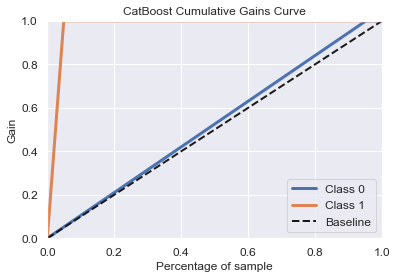

In [61]:
skplt.metrics.plot_cumulative_gain(y_pred, proba)
plt.title('CatBoost Cumulative Gains Curve')
plt.show()

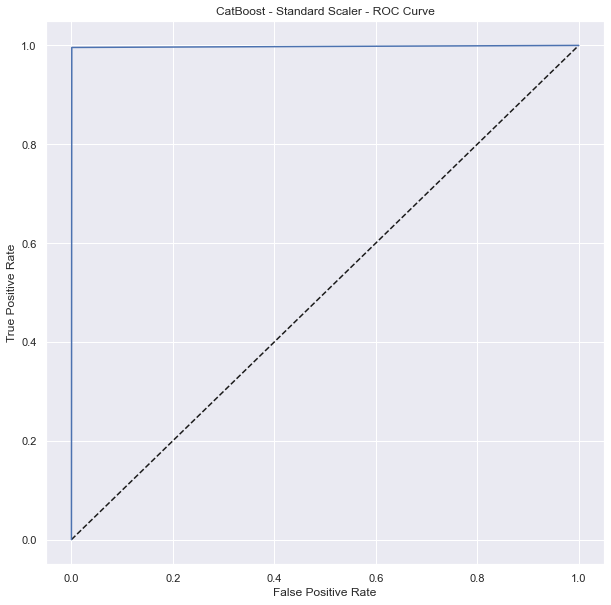

In [62]:
plot_roc(y, y_pred, 'CatBoost', 'Standard Scaler')

### RANDOM FOREST

In [22]:
def random_forest(X, y, estimators=50):
    
    # Initialize scale and classifier pipeline 
    model = Pipeline([('standard_scaler', StandardScaler()), 
                      ('random_forest', RandomForestClassifier(n_estimators=estimators, 
                                                               max_features="auto", 
                                                               random_state=42))])
    print(f'\nTraining {type} Random Forest Model..........')
    
    # Fit a Random Forest model
    model.fit(X, y.values.ravel())
    print('\nModel Trained')
    
    # Predict the target on the dataset
    y_pred = model.predict(X)
    print(f'\nTarget on data {y_pred}')
    
    # Accuracy Score on dataset
    accuracy = accuracy_score(y, y_pred)
    print(f'\nAccuracy_score on dataset : {accuracy}')
    
    # Predict the probability score for each label
    proba_list = model.predict_proba(X)
    print(f'\nProbability score for each label: {proba_list}')
    
    # Get Feature Importance
    plt.figure(figsize=(10,10))
    feat_importances = pd.Series(model.named_steps['random_forest'].feature_importances_, index=X.columns)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.title('Random Forest Feature Importance')
    plt.show()
    
    return y, y_pred, proba_list


Training <class 'type'> Random Forest Model..........

Model Trained

Target on data [1 1 1 ... 0 0 0]

Accuracy_score on dataset : 0.9999499098377079

Probability score for each label: [[0.14 0.86]
 [0.08 0.92]
 [0.04 0.96]
 ...
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]]


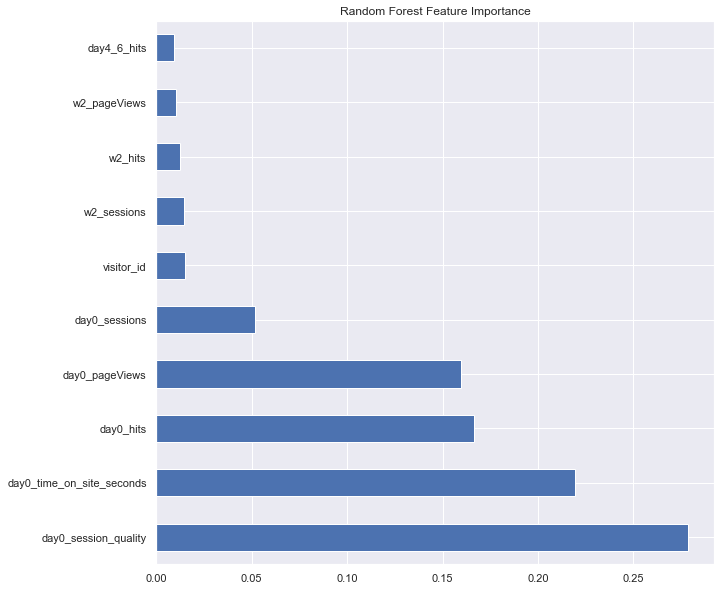

In [23]:
y, y_pred, proba = random_forest(X, y)

In [24]:
df = pd.DataFrame({'label' : y_pred, 'proba' : proba[:,1]})

In [25]:
lift_rdf = lift(df)
lift_rdf.to_csv('metrics/lift_random_forest.csv')
lift_rdf

,label_neg,ntile,count_neg,label_pos,count_pos,lift
0,0,1,1997,1,0,0.000000
1,0,2,1996,1,0,0.000000
2,0,3,1996,1,0,0.000000
3,0,4,1997,1,0,0.000000
4,0,5,1996,1,0,0.000000
5,0,6,1996,1,0,0.000000
6,0,7,1997,1,0,0.000000
7,0,8,1996,1,0,0.000000
8,0,9,1996,1,0,0.000000
9,0,10,1032,1,965,18.409884


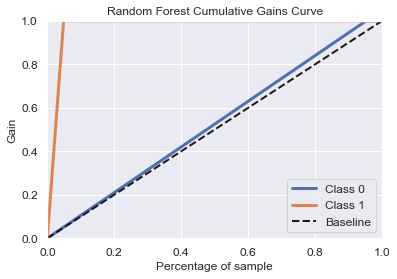

In [26]:
skplt.metrics.plot_cumulative_gain(y_pred, proba)
plt.title('Random Forest Cumulative Gains Curve')
plt.show()

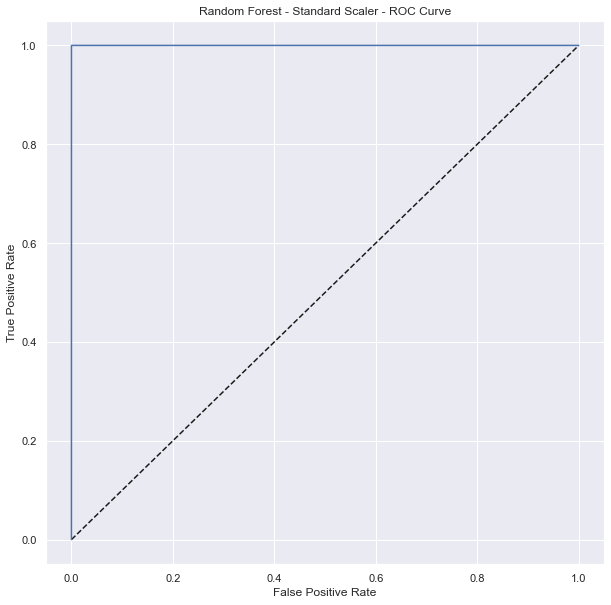

In [27]:
plot_roc(y, y_pred, 'Random Forest', 'Standard Scaler')

### LOGISTIC REGRESSION

In [28]:
def log_reg(X, y, max_iter=150):
    
    # Initialize classifier 
    model = Pipeline([('standard_scaler', StandardScaler()), 
                     ('logistic_regression', LogisticRegression( max_iter=max_iter))])
    print(f'\nTraining {type} Logistic Regression Model..........')
    
    # Fit a Logistic Regression model
    model.fit(X, y.values.ravel())
    
    # Predict the target on the train dataset
    y_pred = model.predict(X)
    print(f'\nTarget on data: {y_pred}')
    
    # Accuracy Score on train dataset
    accuracy = model.score(X, y_pred)
    print(f'\nAccuracy_score on dataset : {accuracy}')
    
    # Predict the probability score for each label
    proba_list = model.predict_proba(X)
    print(f'\nProbability score for each label: {proba_list}')
    
    # Get Feature Importance
    plt.figure(figsize=(10,10))
    feat_importances = pd.Series(model.named_steps['logistic_regression'].coef_[0], index=X.columns)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.title('Logistic Regression Feature Importance')
    plt.show()
        
    return y, y_pred, proba_list


Training <class 'type'> Logistic Regression Model..........

Target on data: [1 1 1 ... 0 0 0]

Accuracy_score on dataset : 1.0

Probability score for each label: [[0.44958926 0.55041074]
 [0.01870993 0.98129007]
 [0.28253708 0.71746292]
 ...
 [0.99874831 0.00125169]
 [0.99573917 0.00426083]
 [0.99874688 0.00125312]]


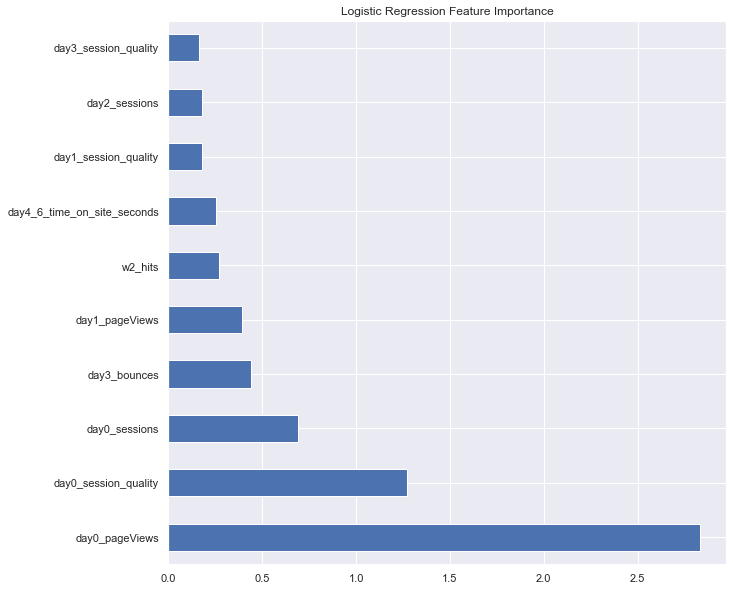

In [29]:
y, y_pred, proba = log_reg(X, y)

In [30]:
df = pd.DataFrame({'label' : y_pred, 'proba' : proba[:,1]})

In [31]:
lift_logreg = lift(df)
lift_logreg.to_csv('metrics/lift_logistic_regression.csv')
lift_logreg

,label_neg,ntile,count_neg,label_pos,count_pos,lift
0,0,1,1997,1,0,0.000000
1,0,2,1996,1,0,0.000000
2,0,3,1996,1,0,0.000000
3,0,4,1997,1,0,0.000000
4,0,5,1996,1,0,0.000000
5,0,6,1996,1,0,0.000000
6,0,7,1997,1,0,0.000000
7,0,8,1996,1,0,0.000000
8,0,9,1996,1,0,0.000000
9,0,10,1050,1,947,18.111429


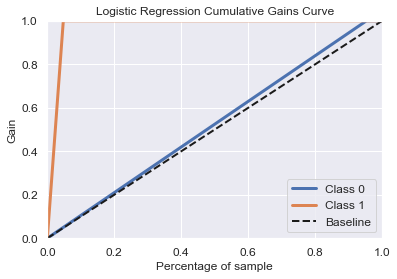

In [32]:
skplt.metrics.plot_cumulative_gain(y_pred, proba)
plt.title('Logistic Regression Cumulative Gains Curve')
plt.show()

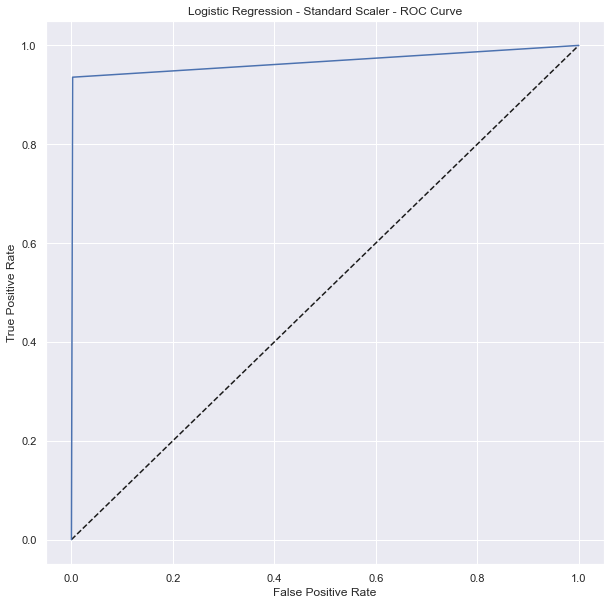

In [33]:
plot_roc(y, y_pred, 'Logistic Regression', 'Standard Scaler')

# RUNNING THE BEST MODEL ON THE VALIDATION SET

In [34]:
#upload training set and change dtypes for visitor_id and label to a categorical object
val = pd.read_csv('data/val_20170301_to_20170314', index_col=0, dtype={'visitor_id': 'object'})
val.head()

,visitor_id,day0_time_on_site_seconds,day1_time_on_site_seconds,day2_time_on_site_seconds,day3_time_on_site_seconds,day4_6_time_on_site_seconds,w2_time_on_site_seconds,day0_hits,day1_hits,day2_hits,...,day3_sessions,day4_6_sessions,w2_sessions,day0_session_quality,day1_session_quality,day2_session_quality,day3_session_quality,day4_6_session_quality,w2_session_quality,label
0,2801499422088453532,139.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1
1,9697633748020539508,284.0,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1
2,49628940161747998,171.0,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1
3,6056987916550791423,178.0,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1
4,3996687359433676152,222.0,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1


In [35]:
val.label.value_counts()/len(val.label)

0    0.981658
1    0.018342
Name: label, dtype: float64

In [36]:
val.fillna(0, inplace=True)

X = val.iloc[:,:-1]
y = val[['label']]


Training CatBoost Model..........
Learning rate set to 0.5
0:	learn: 0.0471629	total: 7.52ms	remaining: 368ms
1:	learn: 0.0165207	total: 14.4ms	remaining: 345ms
2:	learn: 0.0122781	total: 22.7ms	remaining: 356ms
3:	learn: 0.0106345	total: 29.2ms	remaining: 336ms
4:	learn: 0.0099753	total: 37.8ms	remaining: 340ms
5:	learn: 0.0097546	total: 46.6ms	remaining: 342ms
6:	learn: 0.0094112	total: 54.6ms	remaining: 335ms
7:	learn: 0.0086479	total: 61.6ms	remaining: 323ms
8:	learn: 0.0084144	total: 68.4ms	remaining: 312ms
9:	learn: 0.0079344	total: 77.6ms	remaining: 310ms
10:	learn: 0.0075371	total: 85.7ms	remaining: 304ms
11:	learn: 0.0074454	total: 93.7ms	remaining: 297ms
12:	learn: 0.0069228	total: 102ms	remaining: 290ms
13:	learn: 0.0066326	total: 110ms	remaining: 283ms
14:	learn: 0.0064876	total: 118ms	remaining: 275ms
15:	learn: 0.0061113	total: 127ms	remaining: 269ms
16:	learn: 0.0058455	total: 135ms	remaining: 262ms
17:	learn: 0.0058098	total: 143ms	remaining: 253ms
18:	learn: 0.0055226

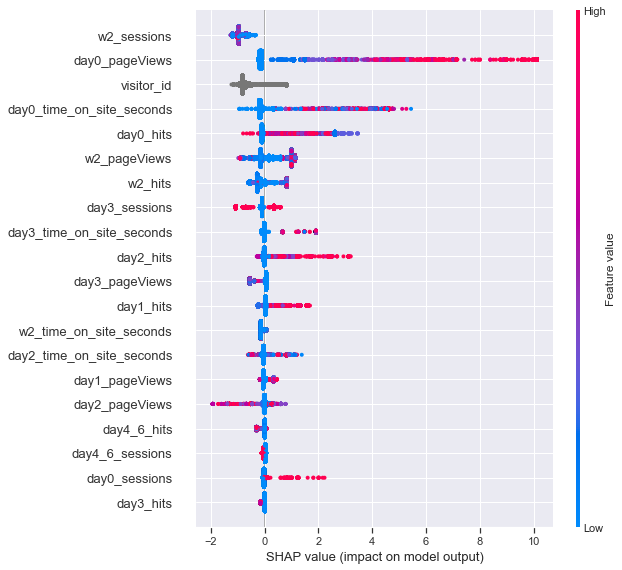

In [37]:
y, y_pred, proba = catboost_model(X, y)

In [38]:
df = pd.DataFrame({'label' : y_pred, 'proba' : proba[:,1]})

In [39]:
lift_val = lift(df)
lift_val.to_csv('metrics/lift_catboost_val.csv')
lift_val

,label_neg,ntile,count_neg,label_pos,count_pos,lift
0,0,1,1936,1,0,0.000000
1,0,2,1935,1,0,0.000000
2,0,3,1936,1,0,0.000000
3,0,4,1935,1,0,0.000000
4,0,5,1936,1,0,0.000000
5,0,6,1935,1,0,0.000000
6,0,7,1935,1,0,0.000000
7,0,8,1936,1,0,0.000000
8,0,9,1935,1,0,0.000000
9,0,10,1578,1,358,12.038657


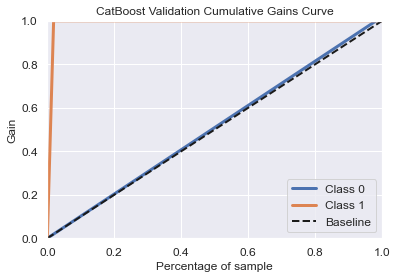

In [40]:
skplt.metrics.plot_cumulative_gain(y_pred, proba)
plt.title('CatBoost Validation Cumulative Gains Curve')
plt.show()

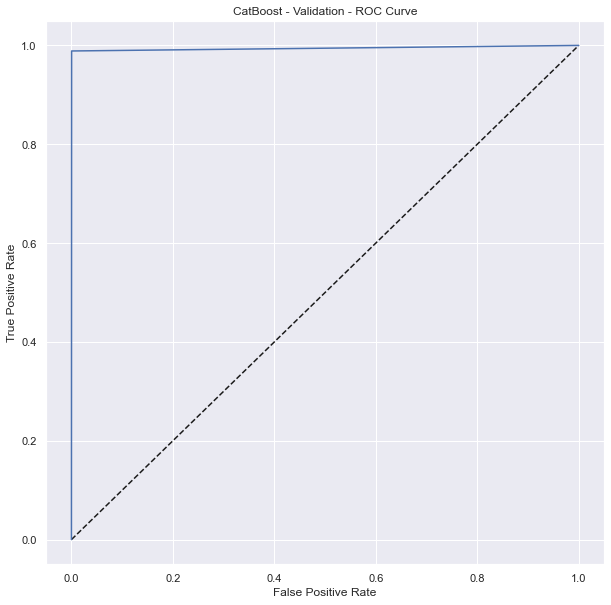

In [41]:
plot_roc(y, y_pred, 'CatBoost', 'Validation')